# Import

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import datetime
from random import choice

In [2]:
df_sales_raw = pd.read_csv("train.csv", low_memory=False)
df_store_raw = pd.read_csv("store.csv", low_memory=False)

# Data preparation

## Merge

In [3]:
df_raw = pd.merge(df_sales_raw, df_store_raw, on="Store", how="left")

## Data Types

In [4]:
df_raw["Date"] = df_raw["Date"].astype("datetime64")

# The other data types will be left to convert after we have dealt with NaN

## Excluding Columns and Rows

In [5]:
df_raw = df_raw[(df_raw["Open"] == 1) & (df_raw["Sales"] > 0)]

# Since we're using the model to predict sales, there's no way of knowing the number of customers in advance
df_raw = df_raw.drop(["Customers", "Open"], axis=1)

## Handling NaN

In [6]:
df_raw.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

In [7]:
max_distance = df_raw.CompetitionDistance.max()
print(max_distance)

75860.0


In [8]:
df_raw["CompetitionDistance"] = df_raw["CompetitionDistance"].fillna(max_distance)

In [9]:
df_raw["CompetitionOpenSinceMonth"] = df_raw.apply(lambda x: x["Date"].month if pd.isna(x["CompetitionOpenSinceMonth"]) else x["CompetitionOpenSinceMonth"], axis=1)

In [10]:
df_raw["CompetitionOpenSinceYear"] = df_raw.apply(lambda x: x["Date"].year if pd.isna(x["CompetitionOpenSinceYear"]) else x["CompetitionOpenSinceYear"], axis=1)

In [11]:
# When there's no promotion, we choose a random interval to try not to introduce biases to the data
df_raw["PromoInterval"] = df_raw["PromoInterval"].apply(lambda x: choice(['Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']) if pd.isna(x) else x)

In [12]:
df_raw["Promo2SinceYear"] = df_raw.apply(lambda x: x["Date"].year if pd.isna(x["Promo2SinceYear"]) else x["Promo2SinceYear"], axis=1)

In [13]:
df_raw["Promo2SinceWeek"] = df_raw.apply(lambda x: x["Date"].week if pd.isna(x["Promo2SinceWeek"]) else x["Promo2SinceWeek"], axis=1)

In [14]:
df_raw["StateHoliday"] = df_raw["StateHoliday"].apply(lambda x: "public_holiday" if x=="a" else "easter" if x=="b" else "christmas" if x=="c" else x)

In [15]:
df_raw["Assortment"] = df_raw["Assortment"].apply(lambda x: "basic" if x=="a" else "extra" if x=="b" else "extended")

In [16]:
# The rest of the type conversions
df_raw["CompetitionOpenSinceMonth"] = df_raw["CompetitionOpenSinceMonth"].astype(int)
df_raw["CompetitionOpenSinceYear"] = df_raw["CompetitionOpenSinceYear"].astype(int)
df_raw["Promo2SinceWeek"] = df_raw["Promo2SinceWeek"].astype(int)
df_raw["Promo2SinceYear"] = df_raw["Promo2SinceYear"].astype(int)

# Descriptive Statistics

In [17]:
df1 = df_raw.copy()
num_attributes = df1.select_dtypes(include=["int64", "float64"])

In [18]:
num_attributes.agg(["mean","median","std","min","max","skew","kurtosis"]).T

,mean,median,std,min,max,skew,kurtosis
Store,558.421374,558.0,321.730861,1.0,1115.0,0.000426,-1.198836
DayOfWeek,3.520350,3.0,1.723712,1.0,7.0,0.019310,-1.259347
Sales,6955.959134,6369.0,3103.815515,46.0,41551.0,1.594929,4.854027
Promo,0.446356,0.0,0.497114,0.0,1.0,0.215824,-1.953425
SchoolHoliday,0.193578,0.0,0.395102,0.0,1.0,1.551109,0.405939
CompetitionDistance,5640.427743,2330.0,8580.824305,20.0,75860.0,3.603153,19.654695
CompetitionOpenSinceMonth,6.787355,7.0,3.309917,1.0,12.0,-0.048451,-1.231875
CompetitionOpenSinceYear,2010.331102,2012.0,5.502628,1900.0,2015.0,-7.217323,123.903078
Promo2,0.498670,0.0,0.499999,0.0,1.0,0.005320,-1.999976
Promo2SinceWeek,23.629083,22.0,14.288315,1.0,52.0,0.170399,-1.194815


[Text(0, 0, 'Basic'), Text(1, 0, 'Extra'), Text(2, 0, 'Extended')]

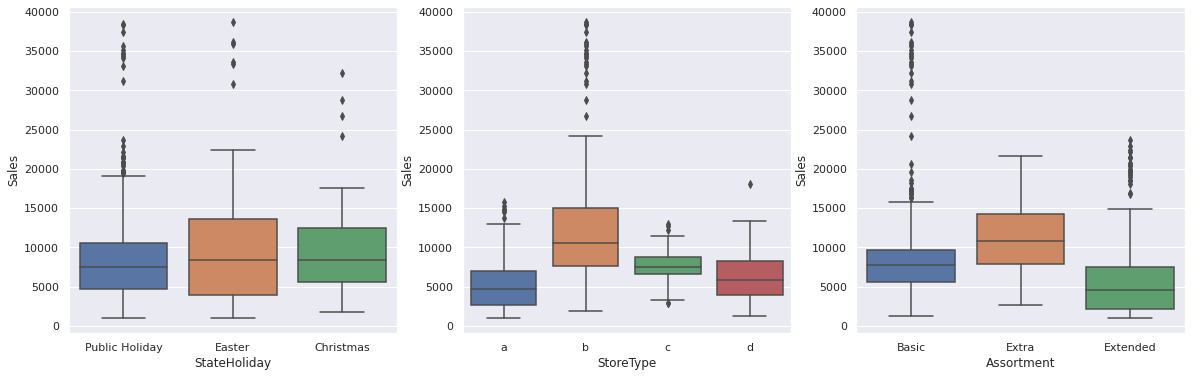

In [67]:
aux = df1[(df1["StateHoliday"] != "0") & (df1["Sales"] > 0)]
fig, ax = plt.subplots(figsize=(20,6))
ax1 = plt.subplot(1,3,1)
sns.boxplot(x="StateHoliday", y="Sales", data=aux, order=["public_holiday","easter","christmas"], ax=ax1)
ax1.set_xticklabels(["Public Holiday","Easter","Christmas"])
ax2 = plt.subplot(1,3,2)
sns.boxplot(x="StoreType", order=["a","b","c","d"], y="Sales", data=aux, ax=ax2)
ax3 = plt.subplot(1,3,3)
sns.boxplot(x="Assortment", y="Sales", order=["basic","extra","extended"], data=aux, ax=ax3)
ax3.set_xticklabels(["Basic", "Extra", "Extended"])

# Feature Engineering

## Hypotheses

1. Stores with closer competition sell less
3. Stores sell less on state holidays
4. Stores sell less on school holidays
5. Stores sell more as time goes on
6. Stores sell less on weekends


## Data Manipulation

In [20]:
df2 = df1.copy()

In [21]:
df2["CompetitionSince"] = df2.apply(lambda x: pd.Timestamp( year=x["CompetitionOpenSinceYear"], month=x["CompetitionOpenSinceMonth"], day=1), axis=1)
df2["CompetitionSinceMonths"] = (((df2["Date"] - df2["CompetitionSince"]).apply(lambda x: x.days))/30).astype(int)

In [22]:
df2["Promo2Since"] = (df2["Promo2SinceYear"].astype(str) + "-" + df2["Promo2SinceWeek"].astype(str) + "-1")
df2["Promo2Since"] = df2["Promo2Since"].apply(lambda x: datetime.datetime.strptime(x, "%G-%V-%u"))
df2["Promo2SinceWeeks"] = ((df2["Date"] - df2["Promo2Since"])/7).apply(lambda x: x.days).astype(int)

In [23]:
df2 = df2.drop(columns=["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceWeek", "Promo2SinceYear"])

In [24]:
df2.sample(5)

,Store,DayOfWeek,Date,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,CompetitionSince,CompetitionSinceMonths,Promo2Since,Promo2SinceWeeks
399997,1106,4,2014-07-10,4821,0,0,0,a,extended,5330.0,1,"Jan,Apr,Jul,Oct",2011-09-01,34,2013-07-29,49
932329,975,1,2013-03-18,11927,1,0,0,a,extended,9630.0,1,"Jan,Apr,Jul,Oct",2013-03-01,0,2011-04-04,102
624682,1068,4,2013-12-19,6516,1,0,0,d,extended,5010.0,1,"Jan,Apr,Jul,Oct",2013-12-01,0,2013-01-28,46
726298,104,3,2013-09-18,7500,0,0,0,a,basic,390.0,0,"Mar,Jun,Sept,Dec",2009-06-01,52,2013-09-16,0
110054,785,5,2015-04-24,5010,0,0,0,d,extended,970.0,1,"Feb,May,Aug,Nov",2005-07-01,119,2013-07-29,90


# Exploratory Analysis

In [25]:
df3 = df2.copy()

<AxesSubplot:xlabel='Sales', ylabel='Count'>

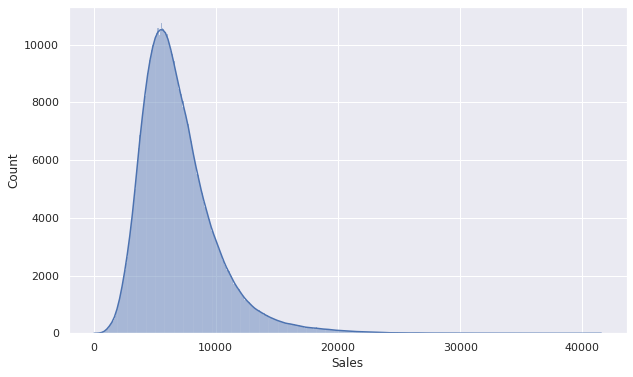

In [79]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(df3["Sales"], kde=True)

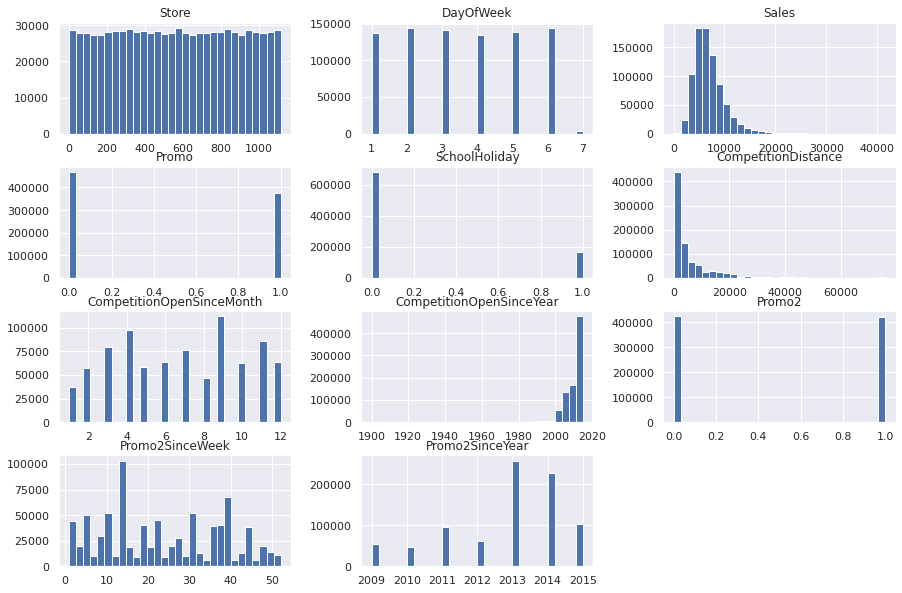

In [69]:
num_attributes.hist(bins=30,figsize=(15,10));

<AxesSubplot:xlabel='Sales', ylabel='Density'>

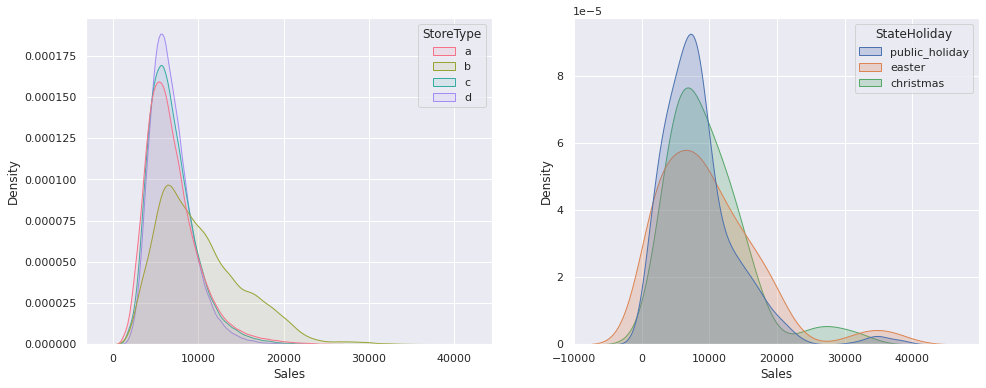

In [ ]:
fig, ax = plt.subplots(figsize=(16,6))
plt.subplot(1,2,1)
sns.kdeplot(data=df3, x="Sales", hue="StoreType", hue_order=["a","b","c","d"], common_norm=False, fill=True, alpha=0.1, palette="husl")
plt.subplot(1,2,2)
sns.kdeplot(data=df3[df3["StateHoliday"]!="0"], x="Sales", hue="StateHoliday", common_norm=False, fill=True)

## Hypothesis: Stores with closer competition sell less

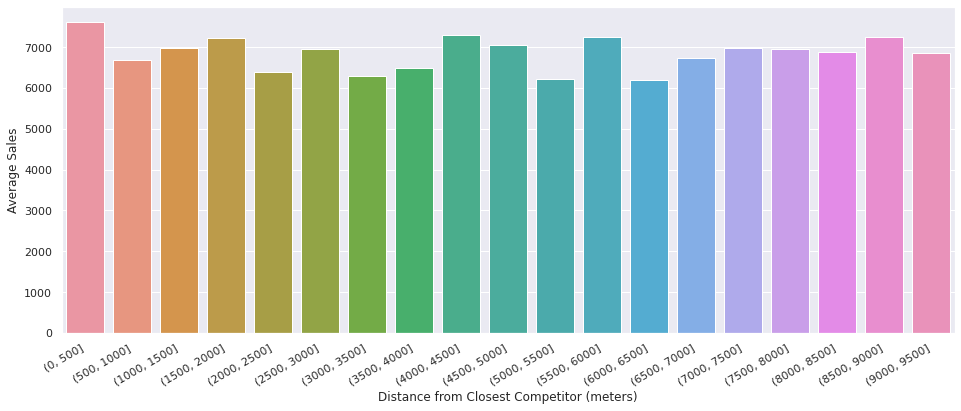

In [134]:
fig, ax = plt.subplots(figsize=(16,6))
aux = df3[["Sales", "CompetitionDistance"]].copy()
aux["DistanceBinned"] = pd.cut(aux["CompetitionDistance"], bins=range(0,10000,500))
aux2 = aux[["Sales", "DistanceBinned"]].groupby("DistanceBinned").mean().reset_index()
sns.barplot(x="DistanceBinned", y="Sales", data=aux2)
ax.set_xlabel("Distance from Closest Competitor (meters)")
ax.set_ylabel("Average Sales")
plt.xticks(rotation=30, horizontalalignment="right");

### Result: There's no significative relation between competition distance and sales